In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import gc
import fpfs
import fitsio
import numpy as np
from fpfs import pltutil
import matplotlib.pylab as plt
import numpy.lib.recfunctions as rfn

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally

ver='try2'
#gver='basic2Shift'
gver='basic2Center'#'cosmo085'
dver='cut16'
wrkDir=os.environ['homeWrk']
simDir=os.path.join(wrkDir,'FPFS2/sim/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# read noiseless data
nver='var0em0' 
mm1=[]
mm2=[]
for _i in range(0,50):
    _a1=fitsio.read(os.path.join(simDir,'srcfs3_%s-%s_%s/psf60/fpfs-%s-%04d-g1-0000.fits' %(gver,nver,ver,dver,_i)))
    _a2=fitsio.read(os.path.join(simDir,'srcfs3_%s-%s_%s/psf60/fpfs-%s-%04d-g1-2222.fits' %(gver,nver,ver,dver,_i)))
    mm1.append(_a1)
    mm2.append(_a2)
    del _a1,_a2#,msk1,msk2
mm1 =   rfn.stack_arrays(mm1,usemask=False)
mm2 =   rfn.stack_arrays(mm2,usemask=False)
gc.collect()

9302

In [33]:
gc.collect()
Const  =   22.
noirev =   False
ellM1  =   fpfs.catalog.fpfsM2E(mm1,const=Const,noirev=noirev)
ellM2  =   fpfs.catalog.fpfsM2E(mm2,const=Const,noirev=noirev)
gc.collect()

0

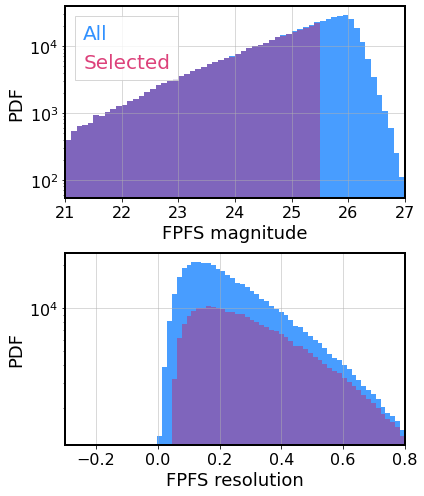

In [34]:
pix_scale=0.168
C=12.
nbins=70
m1   =   -2.5 * np.log10(mm1['fpfs_M00']) + 27.
r2   =   (mm1['fpfs_M20']+mm1['fpfs_M00'])/(mm1['fpfs_M00'])
msk=(m1<25.5)&(r2>=0.05)
plt.close()
fig,axes=pltutil.make_figure_axes(nx=1,ny=2,square=False)
ax=axes[0]
ax.hist(m1,bins=nbins,density=False,linewidth=2.,color=pltutil.colors[1],range=(20,27),label='All',alpha=0.8,histtype='stepfilled')
ax.hist(m1[msk],bins=nbins,density=False,linewidth=2.,color=pltutil.colors[2],range=(20,27),label='Selected',alpha=0.4,histtype='stepfilled')

leg=ax.legend(loc='upper left',fontsize=20,handlelength=0,handletextpad=0,fancybox=False,markerscale=0)
for it,text in enumerate(leg.get_texts()):
    text.set_color(pltutil.colors[it+1])
ax.set_xlim(21,27)
ax.set_yscale('log')
ax.set_xlabel('FPFS magnitude')
ax.set_ylabel('PDF')
ax.grid()

ax=axes[1]
ax.hist(r2,bins=nbins,density=False,linewidth=2.,color=pltutil.colors[1],range=(-0.3,0.8),alpha=0.8,histtype='stepfilled')
ax.hist(r2[msk],bins=nbins,density=False,linewidth=2.,color=pltutil.colors[2],range=(-0.3,0.8),alpha=0.4,histtype='stepfilled')
ax.set_xlim(-0.3,0.8)
ax.set_yscale('log')
ax.set_xlabel('FPFS resolution')
ax.set_ylabel('PDF')
ax.grid()
fig.tight_layout()


gc.collect()
fig.savefig('obsHist.pdf')

In [35]:
#del fs1,fs2
gc.collect()
use_sig=False
fs1=fpfs.catalog.summary_stats(mm1,ellM1,use_sig)
fs2=fpfs.catalog.summary_stats(mm2,ellM2,use_sig)

selnm=['detect','R2','M00']
dcc=-0.6
cutB=27.
cutsig=[0.1,0.05,1.]

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,6):
    # clean outcome
    fs1.clear_outcomes()
    fs2.clear_outcomes()
    mcut=cutB+dcc*i
    cut=[0.1,0.08,10**((27-mcut)/2.5)]
    print(mcut,cut)
    # weight array
    fs1.update_selection_weight(selnm,cut,cutsig);fs2.update_selection_weight(selnm,cut,cutsig)
    fs1.update_selection_bias(selnm,cut,cutsig);fs2.update_selection_bias(selnm,cut,cutsig)
    fs1.update_ellsum();fs2.update_ellsum()
    de   = fs2.sumE1-fs1.sumE1
    eA   = (fs1.sumE1+fs2.sumE1)/2.
    eAR  = (fs1.sumE1+fs2.sumE1+fs1.corE1+fs2.corE1)/2.
    rave = (fs1.sumR1+fs2.sumR1)/2.
    raveR= (fs1.sumR1+fs2.sumR1+fs1.corR1+fs2.corR1)/2.
    x.append(mcut)
    y1.append(de/rave/0.04-1);y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR/0.04)
    z1.append(eA/rave);z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR)

27.0 [0.1, 0.08, 1.0]
26.4 [0.1, 0.08, 1.7378008287493778]
25.8 [0.1, 0.08, 3.0199517204020143]
25.2 [0.1, 0.08, 5.24807460249773]
24.6 [0.1, 0.08, 9.120108393559086]
24.0 [0.1, 0.08, 15.848931924611133]


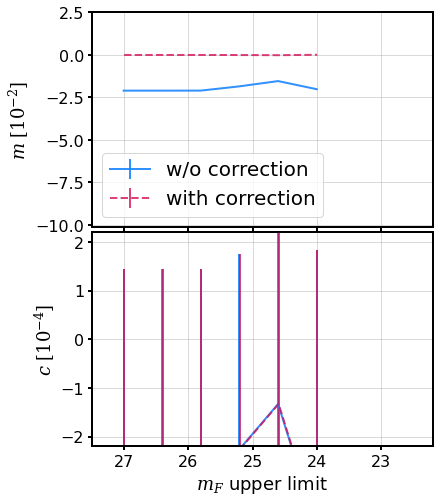

In [36]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$m_{F}$ upper limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.zeros(len(yerr))*1e2,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.zeros(len(yerr))*1e2,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(22.2,27.5)
ax.set_ylim(-10.1,2.5)
ax.tick_params(width=2,size=4)
ax.set_xticklabels([])
ax.grid()
ax.invert_xaxis()
ax.legend()
ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(22.2,27.5)
ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
#hist,bins=np.histogram(fs1.mm['fpfs_M00'],range=(-0.05,0.46),bins=100,density=True)
#cbin=(bins[1:]+bins[:-1])/2.
#sf=hist.max()/2.
#hist=hist/sf
#ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()
ax.invert_xaxis()

plt.tight_layout(h_pad=-0.2)

In [29]:
if False:
    del fs1,fs2
gc.collect()
use_sig=False
fs1=fpfs.catalog.summary_stats(mm1,ellM1,use_sig)
fs2=fpfs.catalog.summary_stats(mm2,ellM2,use_sig)

selnm=['detect','R2','M00']
dcc=0.05
cutB=0.05
cutsig=[0.1,0.05,1.]

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,8):
    # clean outcome
    fs1.clear_outcomes()
    fs2.clear_outcomes()
    cut=cutB+dcc*i
    print(cut)
    cut=[cut,0.08,1.]
    # weight array
    fs1.update_selection_weight(selnm,cut,cutsig);fs2.update_selection_weight(selnm,cut,cutsig)
    fs1.update_selection_bias(selnm,cut,cutsig);fs2.update_selection_bias(selnm,cut,cutsig)
    fs1.update_ellsum();fs2.update_ellsum()
    de   = fs2.sumE1-fs1.sumE1
    eA   = (fs1.sumE1+fs2.sumE1)/2.
    eAR  = (fs1.sumE1+fs2.sumE1+fs1.corE1+fs2.corE1)/2.
    rave = (fs1.sumR1+fs2.sumR1)/2.
    raveR= (fs1.sumR1+fs2.sumR1+fs1.corR1+fs2.corR1)/2.
    x.append(cut[0])
    y1.append(de/rave/0.04-1);y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR/0.04)
    z1.append(eA/rave);z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR)

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4


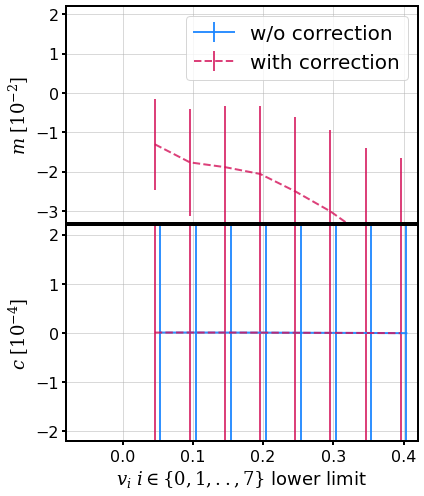

In [30]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$v_{i}~ i \in \{0,1,..,7\}$ lower limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.array(yerr)*1e2,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.array(yerr)*1e2,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(-0.08,0.42)
ax.set_ylim(-3.3,2.2)
ax.tick_params(width=2,size=4)
ax.set_xticklabels([])
ax.grid()
ax.legend()
ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(-0.08,0.42)
ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
#hist,bins=np.histogram(fs1.mm['fpfs_M00'],range=(-0.05,0.46),bins=100,density=True)
#cbin=(bins[1:]+bins[:-1])/2.
#sf=hist.max()/2.
#hist=hist/sf
#ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()

plt.tight_layout(h_pad=-0.2)

In [23]:
0.006/0.168**2.

0.21258503401360543

In [24]:
0.004/0.168**2.

0.1417233560090703

(array([0.00000e+00, 0.00000e+00, 1.00000e+00, 3.00000e+00, 5.61850e+04,
        1.98620e+05, 1.94953e+05, 1.90653e+05, 1.85875e+05, 1.78379e+05,
        1.74583e+05, 1.71436e+05, 1.73093e+05, 1.74247e+05, 1.78658e+05,
        1.80230e+05, 1.80952e+05, 1.70244e+05, 1.40060e+05, 1.36455e+05,
        1.36572e+05, 1.31772e+05, 1.16823e+05, 9.22270e+04, 6.96990e+04,
        5.26290e+04, 4.14160e+04, 3.32560e+04, 2.69750e+04, 2.23410e+04,
        1.90510e+04, 1.61740e+04, 1.39840e+04, 1.22910e+04, 1.07310e+04,
        9.57200e+03, 8.54900e+03, 7.72900e+03, 6.84500e+03, 6.18900e+03,
        5.93700e+03, 5.23500e+03, 4.81800e+03, 4.41400e+03, 4.07700e+03,
        3.79100e+03, 3.62700e+03, 3.25900e+03, 3.08500e+03, 2.90800e+03]),
 array([-0.3  , -0.274, -0.248, -0.222, -0.196, -0.17 , -0.144, -0.118,
        -0.092, -0.066, -0.04 , -0.014,  0.012,  0.038,  0.064,  0.09 ,
         0.116,  0.142,  0.168,  0.194,  0.22 ,  0.246,  0.272,  0.298,
         0.324,  0.35 ,  0.376,  0.402,  0.428,  0.4

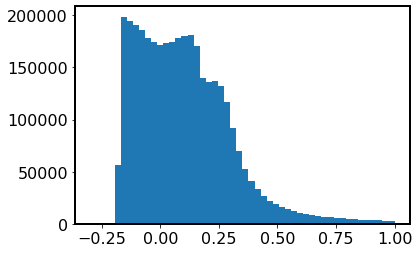

In [27]:
plt.hist(mm1['fpfs_v0'],range=(-0.3,1),bins=50)

(array([  9162.,  21082.,  37904.,  56888.,  77130.,  97515., 115488.,
        132798., 149056., 163850., 179712., 194348., 204170., 209754.,
        214547., 207491., 194398., 177456., 157330., 138193., 121203.,
        108395.,  96178.,  82251.,  67872.,  54777.,  42828.,  34602.,
         28128.,  23092.,  19479.,  16563.,  14233.,  12122.,  10846.,
          9694.,   8548.,   7668.,   7055.,   6283.,   5752.,   5273.,
          4849.,   4479.,   4202.,   3797.,   3557.,   3344.,   3047.,
          2819.]),
 array([-0.3  , -0.274, -0.248, -0.222, -0.196, -0.17 , -0.144, -0.118,
        -0.092, -0.066, -0.04 , -0.014,  0.012,  0.038,  0.064,  0.09 ,
         0.116,  0.142,  0.168,  0.194,  0.22 ,  0.246,  0.272,  0.298,
         0.324,  0.35 ,  0.376,  0.402,  0.428,  0.454,  0.48 ,  0.506,
         0.532,  0.558,  0.584,  0.61 ,  0.636,  0.662,  0.688,  0.714,
         0.74 ,  0.766,  0.792,  0.818,  0.844,  0.87 ,  0.896,  0.922,
         0.948,  0.974,  1.   ]),
 <BarContainer obj

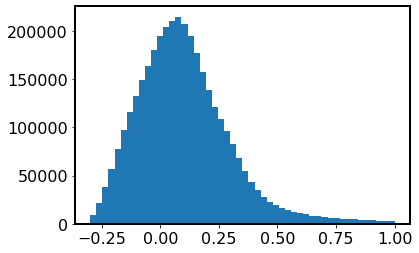

In [28]:
plt.hist(mm1['fpfs_v1'],range=(-0.3,1),bins=50)

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 253966., 336595., 337654., 313673., 265034.,
        223253., 186924., 160867., 139272., 118144., 102470.,  90154.,
         79829.,  69625.,  60562.,  54338.,  48825.,  43997.,  39285.,
         35816.,  32541.,  29391.,  27204.,  25012.,  22523.,  21268.,
         20229.,  18647.,  17664.,  16024.,  15273.,  14475.,  13297.,
         12399.,  11895.,  11411.,  10564.,   9881.,   9437.,   8876.,
          8433.]),
 array([-0.1  ,  0.102,  0.304,  0.506,  0.708,  0.91 ,  1.112,  1.314,
         1.516,  1.718,  1.92 ,  2.122,  2.324,  2.526,  2.728,  2.93 ,
         3.132,  3.334,  3.536,  3.738,  3.94 ,  4.142,  4.344,  4.546,
         4.748,  4.95 ,  5.152,  5.354,  5.556,  5.758,  5.96 ,  6.162,
         6.364,  6.566,  6.768,  6.97 ,  7.172,  7.374,  7.576,  7.778,
         7.98 ,  8.182,  8.384,  8.586,  8.788,  8.99 ,  9.192,  9.394,
         9.596,  9.798, 10.   ]),
 <BarContainer obj

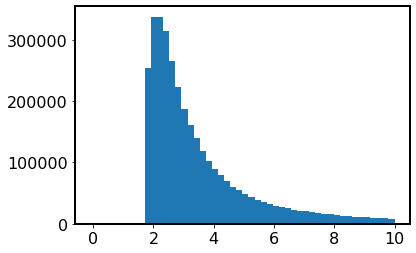

In [23]:
plt.hist(mm1['fpfs_M00'],range=(-0.1,10),bins=50)